# Visualization of Coronavirus Spread

Reads the downloaded datafiles into a timeseries dataframe. Then resamples to create an image for each day.

Author: [P. Daniel Tyreus](https://github.com/pdtyreus) 
```sh
pip install pandas
pip install requests
pip install geopandas
pip install descartes
brew install imagemagick  # for MacOS user
```


## Read the data files

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import geopandas
import numpy as np
import glob
from datetime import datetime
from geodata_functions import *
import re

#Generate inline plots
%matplotlib inline

files = [f for f in glob.glob("../data/rawData/csse_*.csv")]

dfs = []
columns = ['Province/State','Country/Region','Last Update','Confirmed']
for f in files:
    df = pd.read_csv(f,parse_dates=['Last Update'],usecols=columns)
    dfs.append(df)
    
    
df = pd.concat(dfs)
df.head()

,Province/State,Country/Region,Last Update,Confirmed
0,Hubei,Mainland China,2020-01-31 14:00:00,5806.0
1,Zhejiang,Mainland China,2020-01-31 14:00:00,538.0
2,Guangdong,Mainland China,2020-01-31 14:00:00,436.0
3,Henan,Mainland China,2020-01-31 14:00:00,352.0
4,Hunan,Mainland China,2020-01-31 14:00:00,332.0


## Clean the data

The data format changes over time, so we need to clean it a little. Specifically, we need to rename instances of the country UK to "United Kingdom". Then we need to convert instances of a US city, state (e.g. Chicago, IL) back to just a state.

In [2]:
# correct UK to United Kingdom
uk_idx = df['Country/Region'] == 'UK'
df.loc[uk_idx, 'Country/Region'] = 'United Kingom'

# convert state abbreviations to names
regex = r'^((?:\w+[ \-]?){1,4}), ([A-Z]{,2})$'
def city_state_to_state(row):
    text = row['Province/State']
    if pd.isna(text):
        return text
    
    match = re.match(regex, text)
    if match is None:
        return text
    group = match.groups()
    state = states_abbr_to_full[group[1]]
    return state

df['Province/State'] = df.apply(city_state_to_state, axis=1)

Create a new colutm called `Location` to use as a grouping key. See the `create_location` function in `geodata_functions.py`.

Then group the data by `Location` and resample the on `Last Update` column to get an average `Confirmed` reading for each day.

In [14]:
df['Location'] = df.apply(create_location, axis=1)

daily_confirmed = df.groupby(
    [pd.Grouper(key = 'Last Update', freq='D'), 'Location']
).agg(
    {'Confirmed': 'mean', 'Province/State': 'first', 'Country/Region': 'first'}
).reset_index()

Create a list of dates so we can loop through them later

In [15]:
dates = daily_confirmed['Last Update'].unique().tolist()
dates.sort()

Drop `NaN` confirmed values and reindex as a time series

In [16]:
daily_confirmed.dropna(subset=['Confirmed'], inplace = True)

daily_confirmed = daily_confirmed.set_index('Last Update')
daily_confirmed.head()

,Location,Confirmed,Province/State,Country/Region
Last Update,,,,
2020-01-21,"Beijing, Mainland China",10.0,Beijing,Mainland China
2020-01-21,"Chongqing, Mainland China",5.0,Chongqing,Mainland China
2020-01-21,"Guangdong, Mainland China",17.0,Guangdong,Mainland China
2020-01-21,"Henan, Mainland China",1.0,Henan,Mainland China
2020-01-21,"Hubei, Mainland China",270.0,Hubei,Mainland China


## View the data

Select the data from the first day 

In [17]:
d = pd.to_datetime(dates[0])
day_df = daily_confirmed.loc[d]

ncov = build_ncov_geodf(day_df)
ncov[['name','Confirmed','log_confirmed']].sort_values(by='log_confirmed', ascending=False).head()

,name,Confirmed,log_confirmed
8,Hubei,270.0,2.431364
6,Guangdong,17.0,1.230449
4,Beijing,10.0,1.000000
17,Beijing,10.0,1.000000
12,Shanghai,9.0,0.954243


## Plot the first day

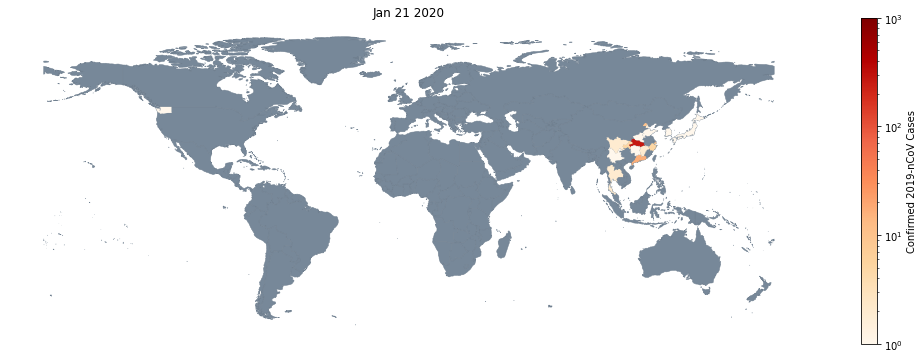

In [18]:
COLOR = 'black'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

world_lines = geopandas.read_file('zip://./shapefiles/ne_50m_admin_0_countries.zip')
world = world_lines[(world_lines['POP_EST'] > 0) & (world_lines['ADMIN'] != 'Antarctica')]

fig, ax = plt.subplots(figsize=(18, 6))

world.plot(
    ax=ax,
    color = "lightslategray", 
    edgecolor = "slategray", 
    linewidth = 0.5);
ax.axis('off')

d = pd.to_datetime(dates[0])
ax.set_title(d.strftime("%b %d %Y"))
day_df = daily_confirmed.loc[d]
ncov = build_ncov_geodf(day_df)

ncov.plot(
    ax=ax, 
    column='Confirmed', 
    norm=colors.LogNorm(vmin=1, vmax=1000),
    legend=True,
    legend_kwds={'label': "Confirmed 2019-nCoV Cases"},
    cmap='OrRd')


## Plot the most recent day

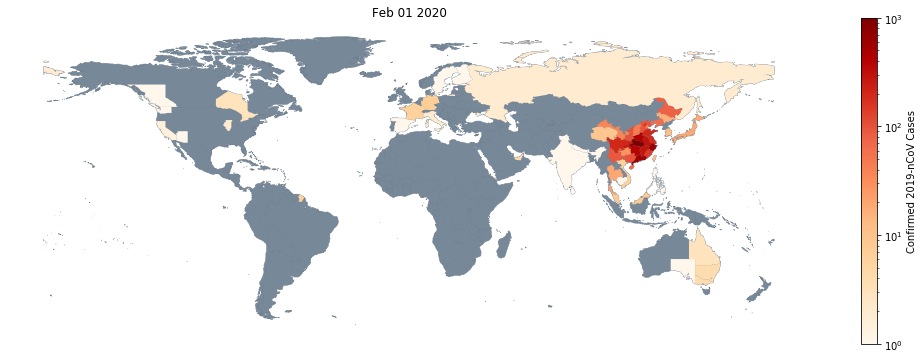

In [19]:
fig, ax = plt.subplots(figsize=(18, 6))

world.plot(
    ax=ax,
    color = "lightslategray", 
    edgecolor = "slategray", 
    linewidth = 0.5);
ax.axis('off')

d = pd.to_datetime(dates[len(dates)-1])
ax.set_title(d.strftime("%b %d %Y"))
day_df = daily_confirmed.loc[d]
ncov = build_ncov_geodf(day_df)

ncov.plot(
    ax=ax, 
    column='Confirmed', 
    norm=colors.LogNorm(vmin=1, vmax=1000),
    legend=True,
    legend_kwds={'label': "Confirmed 2019-nCoV Cases"},
    cmap='OrRd')

## Generate image files

Loop over all dates and export as image files.

To generate a an animated GIF, run

```sh
cd out
brew install imagemagick  # for MacOS user
convert -delay 75 *.png ncov.gif
```

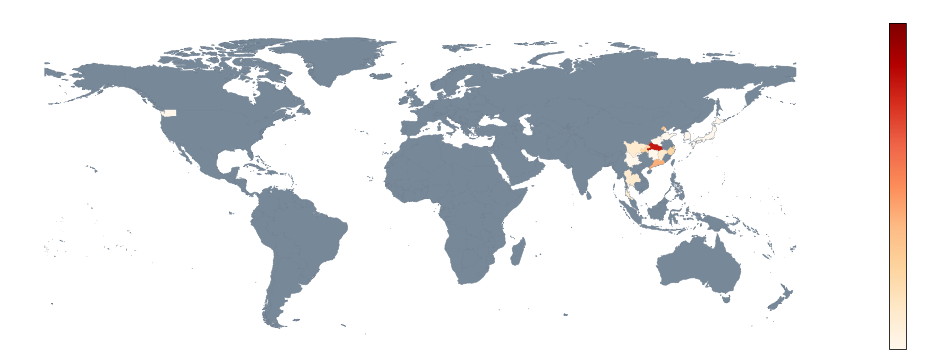

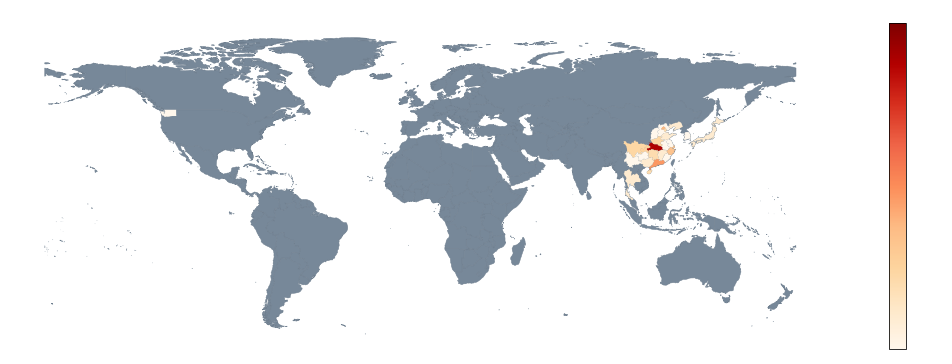

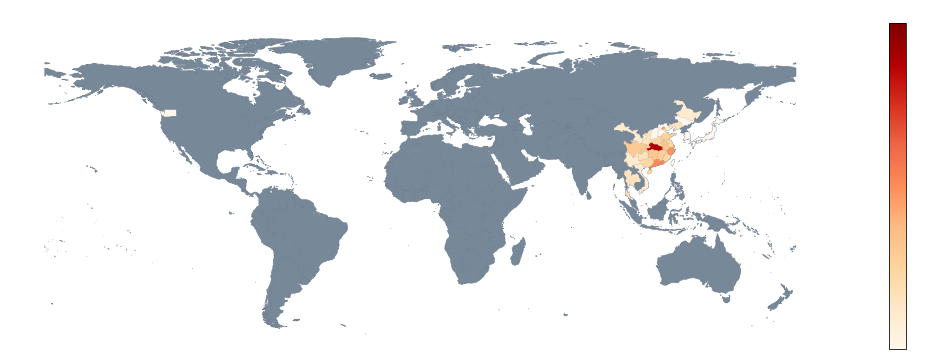

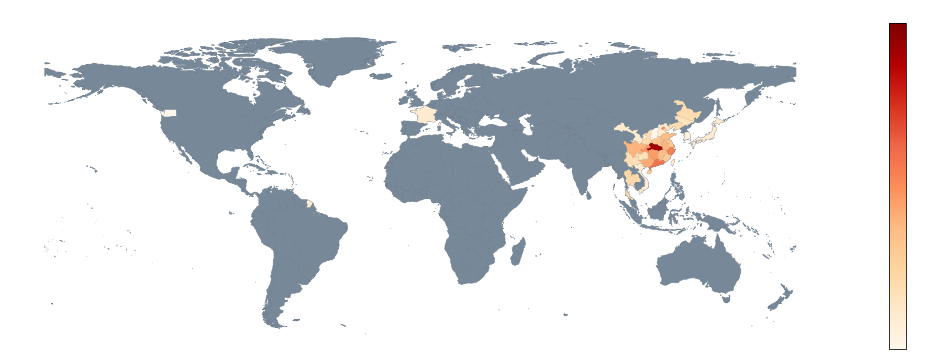

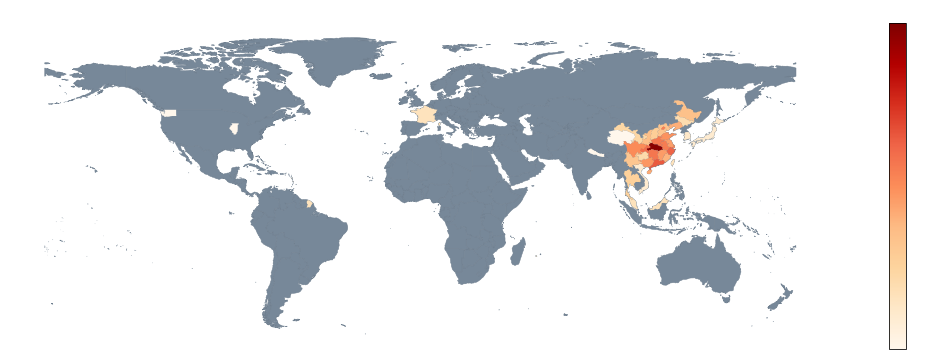

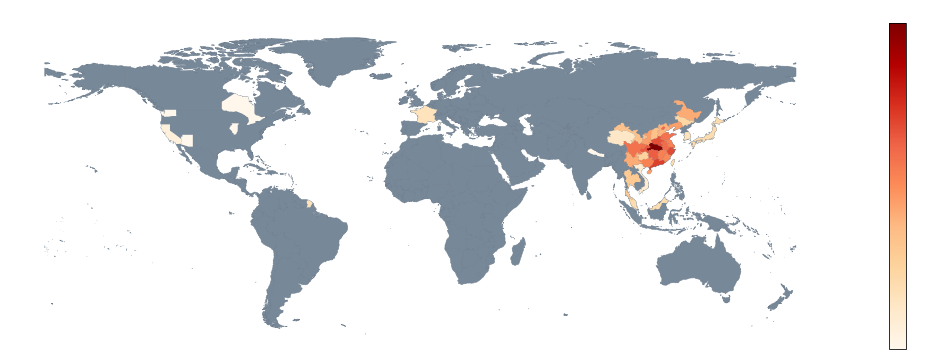

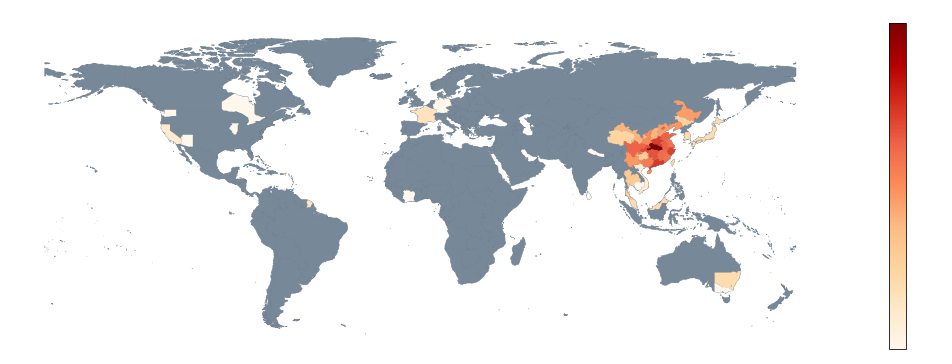

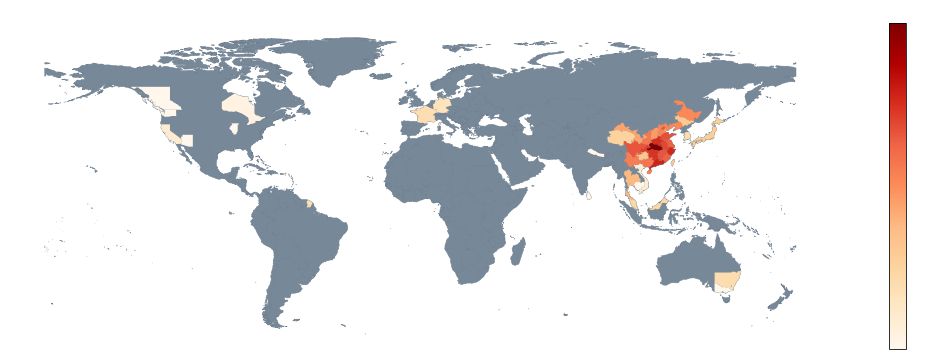

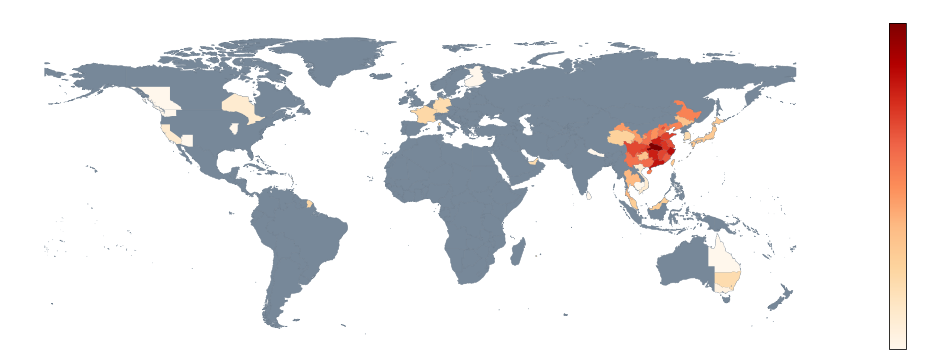

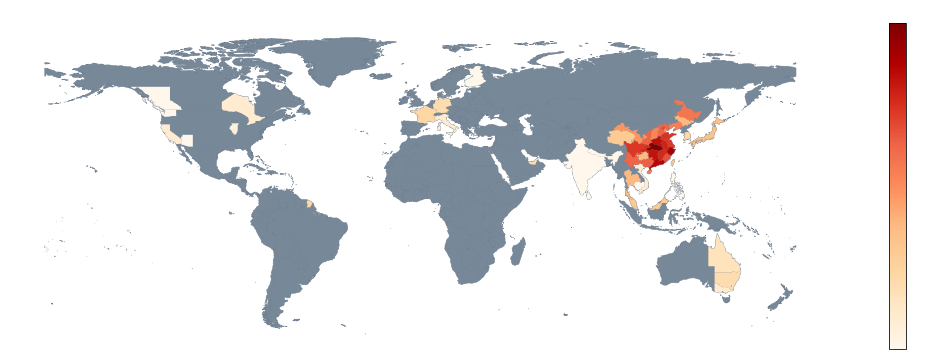

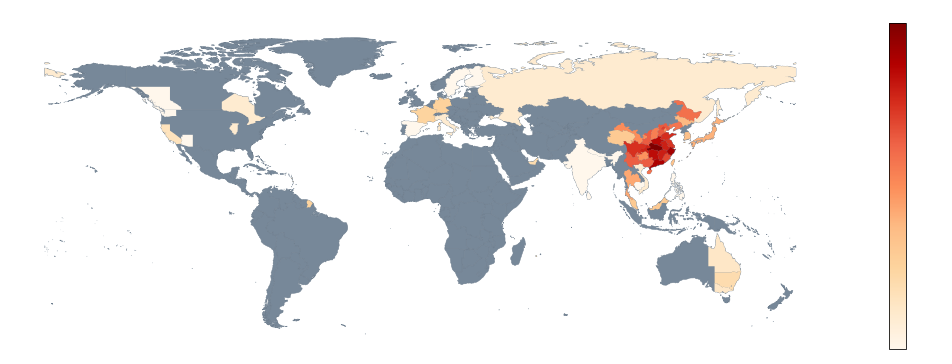

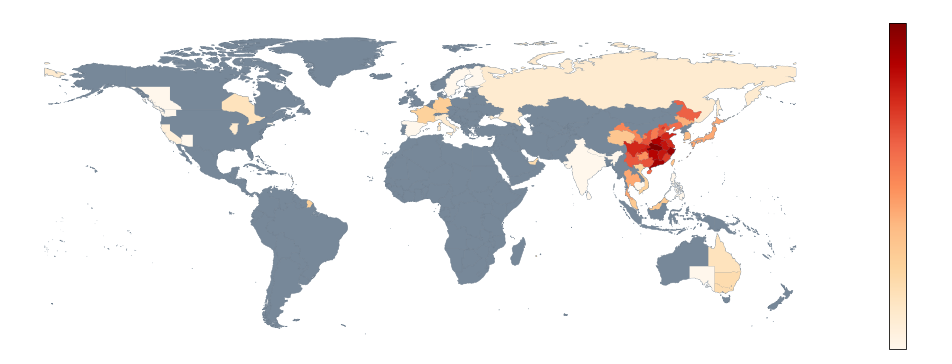

In [24]:
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

i = 0
for date in dates:
    fig, ax = plt.subplots(figsize=(20, 6))
    
    world.plot(
        ax=ax,
        color = "lightslategray", 
        edgecolor = "slategray", 
        linewidth = 0.5);
    
    ax.axis('off')

    d = pd.to_datetime(date)
    ax.set_title(d.strftime("%b %d %Y"))
    day_df = daily_confirmed.loc[d]
    ncov = build_ncov_geodf(day_df)
    
    ncov.plot(
        ax=ax, 
        column='Confirmed', 
        norm=colors.LogNorm(vmin=1, vmax=1000),
        legend=True,
        legend_kwds={'label': "Confirmed 2019-nCoV Cases"},
        cmap='OrRd')
    
    i += 1
    fig.savefig('./out/' + '{0:03d}'.format(i) + '.png', facecolor='slategrey', dpi=300, bbox_inches='tight')